## **Facial Expression Recognition Using CLIP Encoders and FER2013 Dataset**

In [14]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

**Device Configuration**

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Data Preprocessing and Loading**
* Load and Preprocess the FER2013 Dataset

In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the FER2013 dataset
train_dataset = datasets.ImageFolder(root='/kaggle/input/fer2013/train', transform=transform)
test_dataset = datasets.ImageFolder(root='/kaggle/input/fer2013/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [24]:
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

**Model Architecture**

In [17]:
class FERModel(nn.Module):
    def __init__(self, num_classes=7):
        super(FERModel, self).__init__()
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.classifier = nn.Linear(512, num_classes)
    
    def forward(self, images):
        # Extract features using the CLIP image encoder
        with torch.no_grad():
            features = self.clip_model.get_image_features(images)
        
        # Classify the features into expression classes
        logits = self.classifier(features)
        return logits

model = FERModel(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

**Training Loop**

In [18]:
num_epochs = 15
model_save_path = 'model'
verbose = True

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/15], Average Loss: 1.5277
Epoch [2/15], Average Loss: 1.2343
Epoch [3/15], Average Loss: 1.1264
Epoch [4/15], Average Loss: 1.0679
Epoch [5/15], Average Loss: 1.0326
Epoch [6/15], Average Loss: 1.0068
Epoch [7/15], Average Loss: 0.9884
Epoch [8/15], Average Loss: 0.9748
Epoch [9/15], Average Loss: 0.9636
Epoch [10/15], Average Loss: 0.9558
Epoch [11/15], Average Loss: 0.9474
Epoch [12/15], Average Loss: 0.9416
Epoch [13/15], Average Loss: 0.9355
Epoch [14/15], Average Loss: 0.9311
Epoch [15/15], Average Loss: 0.9272


**Save model weights**

In [19]:
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

torch.save(model.to('cpu').state_dict(), os.path.join(model_save_path, 'model_weights.pth'))
print(f'Model weights saved (PyTorch .pth format)')

Model weights saved (PyTorch .pth format)


**Model Evaluation Functions**

In [30]:
def evaluate_model(model, test_loader, class_names):
    model.to(device)  # Ensure the model is on the same device as the input data
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Ensure the data is on the same device as the model
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Model Accuracy: {accuracy:.2f}\n')
    
    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

**Prediction Visualization Function**

In [32]:
def visualize_predictions(model, test_loader, class_names, num_samples=5):
    model.eval()
    dataiter = iter(test_loader)
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))
    
    with torch.no_grad():
        for i in range(num_samples):
            images, labels = next(dataiter)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Display image
            ax = axes[i, 0]
            img = images[0].permute(1, 2, 0).cpu().numpy()
            img = (img * 0.225) + 0.45  # Denormalize
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'True: {class_names[labels[0]]}')
            
            # Display prediction probabilities
            ax = axes[i, 1]
            probs = torch.nn.functional.softmax(outputs[0], dim=0)
            sns.barplot(x=class_names, y=probs.cpu().numpy(), ax=ax)
            ax.set_ylim(0, 1)
            ax.set_title(f'Predicted: {class_names[preds[0]]}')
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    
    plt.tight_layout()
    plt.show()

**Evaluate Model Performance**

Model Accuracy: 0.64

Classification Report:
              precision    recall  f1-score   support

       Angry       0.54      0.55      0.54       958
     Disgust       0.82      0.13      0.22       111
        Fear       0.43      0.27      0.33      1024
       Happy       0.84      0.90      0.87      1774
         Sad       0.59      0.68      0.63      1233
    Surprise       0.53      0.55      0.54      1247
     Neutral       0.69      0.75      0.72       831

    accuracy                           0.64      7178
   macro avg       0.63      0.55      0.55      7178
weighted avg       0.63      0.64      0.62      7178



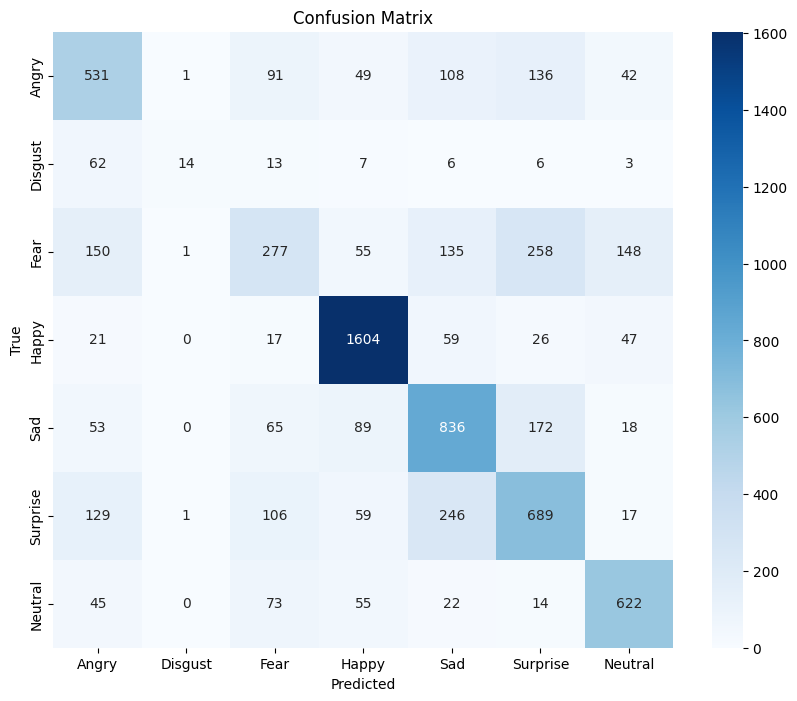

In [33]:
evaluate_model(model, test_loader, class_names)

**Visualize Model Predictions**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/si

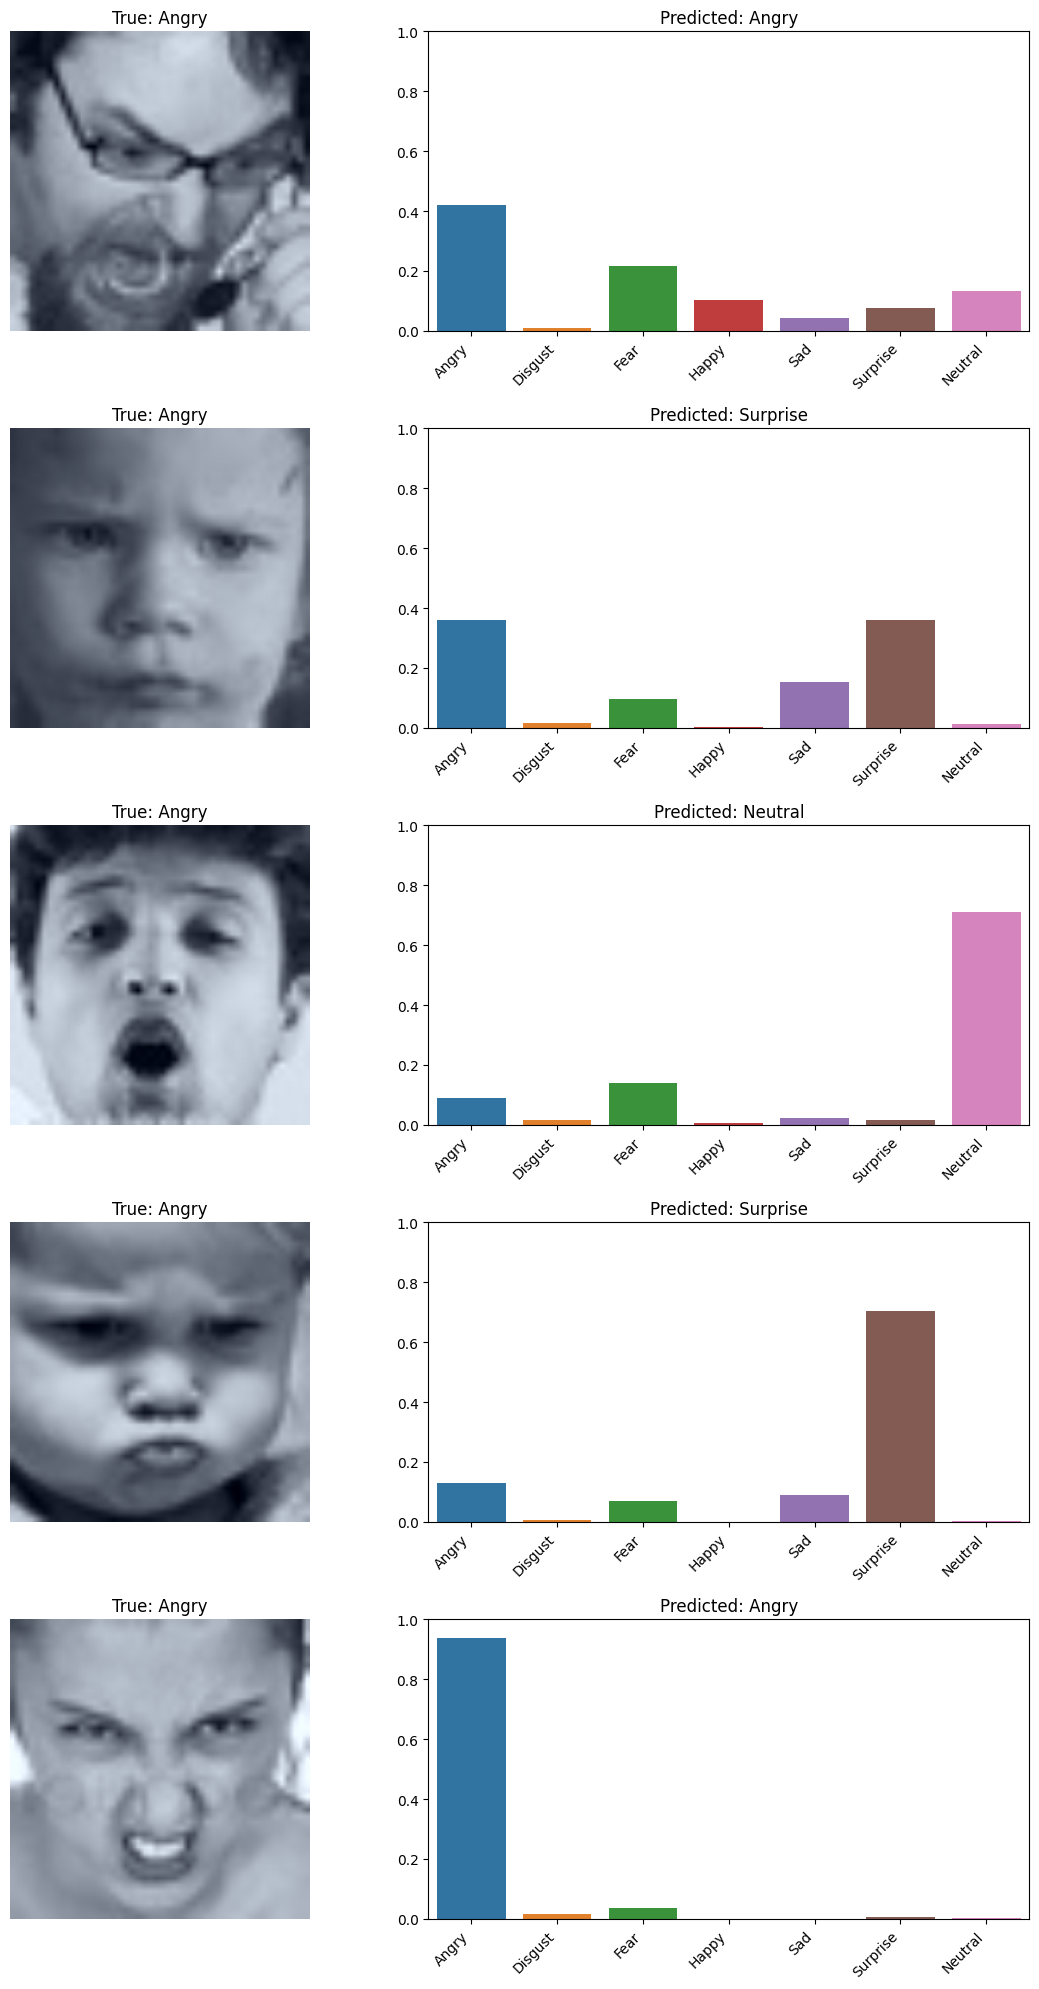

In [36]:
visualize_predictions(model, test_loader, class_names)

In [28]:
from IPython.display import HTML

download_link = f'<a href="./model/model_weights.pth" download>Click here to download model</a>'
HTML(download_link)